---
title: "MLE Polynomial Filtering"
description: "Flexible polynomial-based filtering useing MLE is just easy to program Savitzky-Golay"
author: "Colin Kinz-Thompson"
date: "12/01/2023"
format:
  html:
    toc: true
    code-fold: false
---

# MLE polynomial filtering = Savitzky-Golay filtering
Imagine taking a data vector $y=\{y_i(x_i)\}$ and fitting it to a polynomial, $\sum_{n=0}^N p_n x_i^n$. If the likelihoods are all IID Gaussians such that $y_i\sim\mathcal{N}(y_i\vert\mu=\sum_{n=0}^N p_n x_i^n,\sigma^2)$, i.e., the variance is the same for all datapoints, then the maximum likelihood estimate for the polynomial coefficients can be found by taking the derivative and of the log-likelihood with respect to each coefficient, setting that expression equal to zero, and solving that set of equations. Notably, those expressions are all like

$$0 = \sum_i (y_i - \sum_{n=0}^N p_n x_i^n) x_i^m$$
where this is the one for the derivative with respect to the $m^{th}$ coefficient. The resulting set of equations can be written in matrix form as 

$$ 
\begin{bmatrix}
p^N \\
p^{N-1} \\
\vdots \\
p^0 \\
\end{bmatrix} =
\begin{bmatrix}
\langle x^{2N}\rangle & \langle x^{2N-1}\rangle & \cdots &\cdots & \langle x^{N}\rangle \\
\langle x^{2N-1}\rangle & \langle x^{2N-2}\rangle & \cdots &\cdots & \langle x^{N-1} \rangle \\
\vdots &  & \ddots & & \vdots \\
\vdots & &  & \langle x^{2} \rangle & \langle x^{1} \rangle \\
\langle x^{N} \rangle & \langle x^{N-1} \rangle & \cdots & \langle x^{1} \rangle & 1\\
\end{bmatrix}^{-1} \cdot
\begin{bmatrix}
\langle yx^N \rangle \\
\langle yx^{(N-1)} \rangle \\
\vdots \\
\langle y x^0 \rangle \\
\end{bmatrix}
$$


It turns out that if you take this idea, window it across a large data vector, and replace the center point for each window, then move the window over one data point, you have the [Savitzy-Golay](https://en.wikipedia.org/wiki/Savitzky–Golay_filter) filter. Because it's pretty easy to invert these matrices, rather than program in ever single possible set of convolutional parameters for every possible set of Savitzy-Golay filters, we can just program a very general solution.

In [364]:
import numpy as np
import matplotlib.pyplot as plt

In [365]:
def mle_polynomial(y,o):
    '''
    This function does the MLE estimate of IID homoskedastic normal data where the mean is a polynomial of order, o
    Input:
        * y - the data vector to be filtered (1D np.ndarray)
        * o - the order of the polynomial to use (int) (e.g., 2 for a quadratic)
    Output:
        * smooth - the resulting polynomial evaluted at all the datapoints in y (1D np.ndarray)
    '''
    x = np.arange(y.size).astype('double')
    m = np.zeros((o+1,o+1))
    v = np.array([np.mean(y*x**(o-i)) for i in range(o+1)])
    m[0] = np.array([np.mean(x**(2*o-j)) for j in range(o+1)]) 
    for i in range(1,o+1): ## do it this way to avoid extra computation....
        m[i,:-1] = m[i-1][1:].copy()
        m[i,-1] = np.mean(x**(o-i))
    abc = np.dot(np.linalg.inv(m),v)
    smooth = np.polyval(abc,x)
    return smooth

def flexible_filter(y,o,n):
    ''' This function applies an arbitrarily sized Savitzky-Golay filter
    Input:
        * y - the data vector to be filtered (1D np.ndarray)
        * o - the order of the polynomial to use (int) (e.g., 2 for a quadratic)
        * n - the window size (int) (e.g., 5 for five datapoints at a time)
    Ouput:
        * yy - the Savitzky-Golay filtered data (1D np.ndarray)
    '''
    l=(n-1)//2
    yy = y.copy()
    for i in range(l,y.size-l):
        yy[i] = mle_polynomial(yy[i-l:i+l+1],o)[l]
    return yy

# Proof
Let's simulate some data, filter it, and show that the flexible MLE version matches the traditional convolution-based Savitzky-Golay filter

In [366]:
## See the wikipedia page, second eqation for Y_j: https://en.wikipedia.org/wiki/Savitzky–Golay_filter#Applications
def savitzky_golay_25(y):
    yy = y.copy()
    for i in range(2,y.size-2):
        yy[i] = 1./35*(-3.*yy[i-2] + 12*yy[i-1] + 17*yy[i] + 12*yy[i+1] - 3*yy[i+2])
    return yy

In [367]:
## A random walk
y = (np.random.rand(600)-.5).cumsum()
y += np.random.normal(size=y.size)*.5
x = np.arange(y.size).astype('double') 

## Apply both filters
yy = flexible_filter(y,2,5)
yyy = savitzky_golay_25(y)

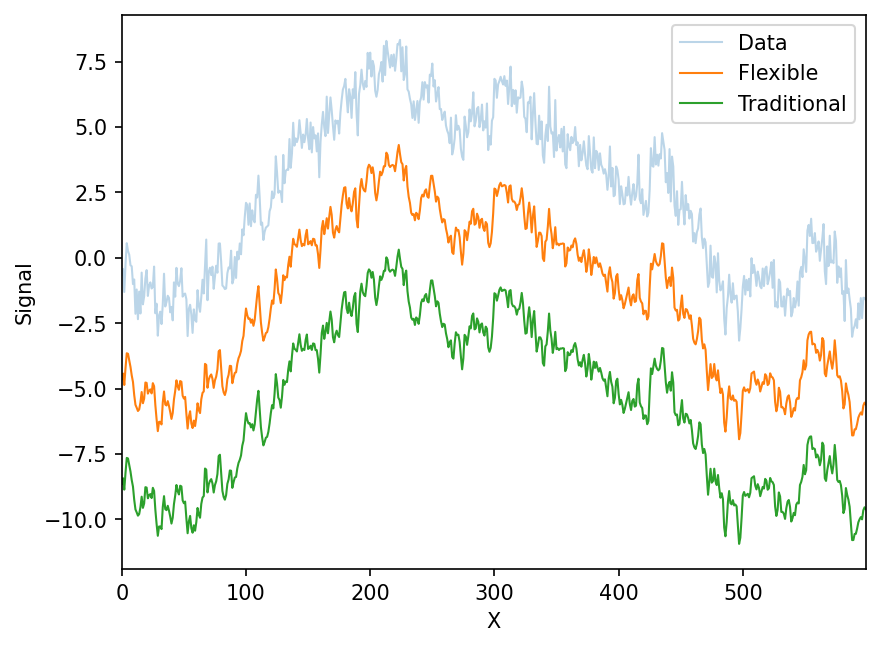

In [368]:
offset = 4
fig,ax=plt.subplots(1,dpi=150)
ax.plot(x,y,label='Data',lw=1,alpha=.3)
ax.plot(x,yy-offset*1,label='Flexible',lw=1)
ax.plot(x,yyy-offset*2,ls='-',label='Traditional',lw=1)

ax.legend()
ax.set_xlim(0,x.max())
ax.set_xlabel('X')
ax.set_ylabel('Signal')
plt.show()

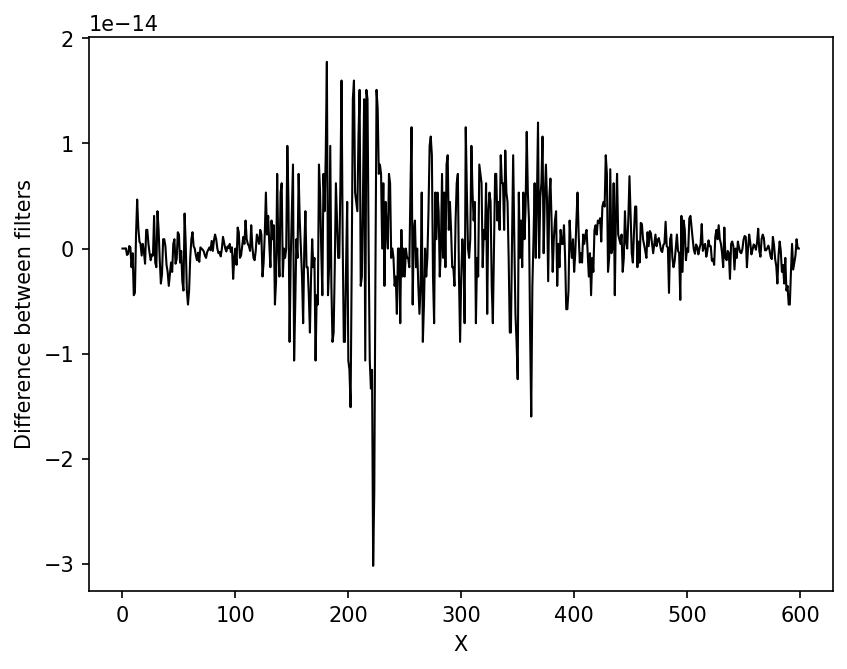

In [369]:
fig,ax=plt.subplots(1,dpi=150)
ax.plot(x,yyy-yy,lw=1,color='k')
ax.set_xlabel('X')
ax.set_ylabel('Difference between filters')
plt.show()

As you can see, the implementation of the filters differ only at the level of numerical accuracy.

# Bigger filters
With the flexible filtering function, we can easily use whatever polynomial order (o) and window size (n). Note the edge effects are because the functions above ignore datapoints that can't fill a window. They can be modified to do so.

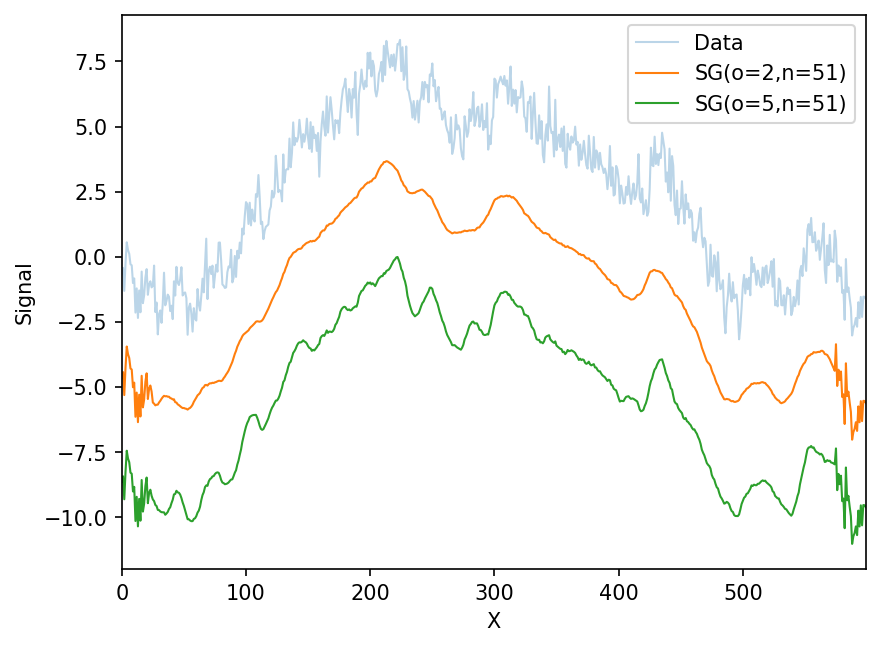

In [373]:
offset =4.
fig,ax=plt.subplots(1,dpi=150)
ax.plot(x,y,label='Data',lw=1,alpha=.3)
ax.plot(x,flexible_filter(y,2,51)-offset*1,label='SG(o=2,n=51)',lw=1)
ax.plot(x,flexible_filter(y,7,51)-offset*2,label='SG(o=5,n=51)',lw=1)

ax.legend()
ax.set_xlim(0,x.max())
ax.set_xlabel('X')
ax.set_ylabel('Signal')

plt.show()


# Other filters
Let's compare to other, more traditional filters. I've manually fine-tuned the filter parameters to give similar resolution

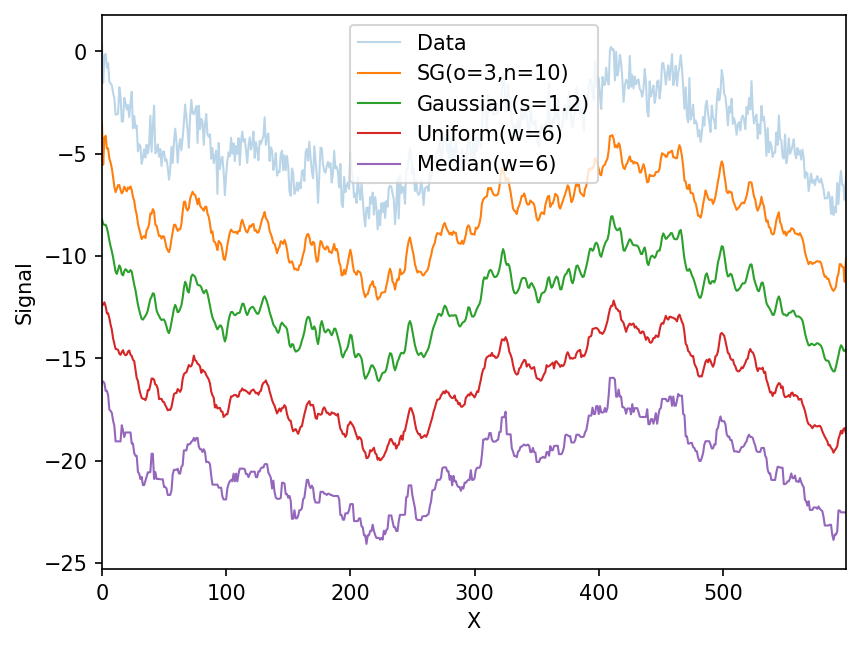

In [363]:
from scipy.ndimage import gaussian_filter, uniform_filter, median_filter

offset = 4.
fig,ax=plt.subplots(1,dpi=150)
ax.plot(x,y,label='Data',lw=1,alpha=.3)
ax.plot(x,flexible_filter(y,3,10)-offset*1,label='SG(o=3,n=10)',lw=1)
ax.plot(x,gaussian_filter(y,1.2)-offset*2,label='Gaussian(s=1.2)',lw=1)
ax.plot(x,uniform_filter(y,6)-offset*3,label='Uniform(w=6)',lw=1)
ax.plot(x,median_filter(y,5)-offset*4,label='Median(w=6)',lw=1)

ax.legend()
ax.set_xlim(0,x.max())
ax.set_xlabel('X')
ax.set_ylabel('Signal')

plt.show()
